In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from tqdm import tqdm
import gc
import yaml
import sys

# ==============================================================================
# 1. CARGA DE CONFIGURAÇÃO (YAML)
# ==============================================================================
def find_project_root(anchor_file="conf/config.yaml"):
    current_path = Path.cwd()
    for parent in [current_path] + list(current_path.parents):
        if (parent / anchor_file).exists(): return parent
    raise FileNotFoundError(f"Raiz do projeto não encontrada.")

try:
    BASE_DIR = find_project_root()
    print(f"📂 Raiz do Projeto: {BASE_DIR}")
except:
    BASE_DIR = Path("/Users/lucasborges/Downloads/TCC") # Fallback
    print(f"⚠️ Fallback: {BASE_DIR}")

with open(BASE_DIR / "conf/config.yaml", "r") as f:
    config = yaml.safe_load(f)

# Atalhos
P = {k: BASE_DIR / v for k, v in config['paths'].items()}
F = config['files']

# ==============================================================================
# 2. DEFINIÇÃO DE CAMINHOS DINÂMICOS
# ==============================================================================
print("Mapeando arquivos de avaliação...")

# Embeddings (Gerados no Notebook 6 e 7)
TRAIN_EMB_PATH = P['processed'] / F['track_embeddings']      # Z_train
NEW_EMB_PATH   = P['processed'] / F['new_track_embeddings']  # Z_new

# Metadados Completos (Para montar histórico e target)
# Se não estiver no F, usamos o nome padrão na pasta interim
TRACKS_COMPLETE_PATH = P['interim'] / "df_tracks_complete_v5.parquet"

# Parâmetros
CUTOFF_YEAR = 2015

# Validação
for path in [TRAIN_EMB_PATH, NEW_EMB_PATH, TRACKS_COMPLETE_PATH]:
    if not path.exists():
        print(f"⚠️ Aviso: Arquivo não encontrado: {path.name}")

# ==============================================================================
# 3. FUNÇÃO DE CARGA E NORMALIZAÇÃO
# ==============================================================================
def load_and_normalize(path, uri_col="track_uri", prefix="emb_mean_"):
    print(f"Carregando: {path.name}...")
    df = pd.read_parquet(path)
    
    # Identificar colunas de embedding automaticamente
    emb_cols = [c for c in df.columns if c.startswith(prefix)]
    
    # Extrair matriz numpy
    Z = df[emb_cols].to_numpy().astype("float32")
    uris = df[uri_col].to_numpy()
    
    # Normalização L2 (Vital para Cosseno ser equivalente a produto escalar)
    norms = np.linalg.norm(Z, axis=1, keepdims=True)
    norms[norms == 0] = 1e-10 # Evitar divisão por zero
    Z_norm = Z / norms
    
    # Criar mapa URI -> Índice da Matriz
    uri2idx = {u: i for i, u in enumerate(uris)}
    
    return Z_norm, uris, uri2idx

# ==============================================================================
# 4. EXECUÇÃO
# ==============================================================================

# 1. Carregar Treino (Histórico/Contexto)
# Representa o conhecimento "passado" do modelo
Z_train, uris_train, train_map = load_and_normalize(TRAIN_EMB_PATH)

# 2. Carregar Teste (Candidatos Cold-Start)
# Representa as músicas "futuras" projetadas via KNN + GNN
Z_new, uris_new, new_map = load_and_normalize(NEW_EMB_PATH)

# Sets para verificação rápida O(1)
train_uri_set = set(uris_train)
new_uri_set = set(uris_new)

print("\n" + "="*40)
print(f"Matriz Treino (Histórico): {Z_train.shape}")
print(f"Matriz Teste (Candidatos): {Z_new.shape}")
print("="*40)

📂 Raiz do Projeto: /Users/lucasborges/Downloads/TCC
Mapeando arquivos de avaliação...
Carregando: track_embeddings_mean.parquet...
Carregando: new_track_embeddings_mean.parquet...

Matriz Treino (Histórico): (321160, 64)
Matriz Teste (Candidatos): (60417, 64)


In [2]:

import re
from typing import List, Dict, Any
import matplotlib.pyplot as plt
import seaborn as sns
from cycler import cycler

def set_academic_style():
    # 1. Paleta de Cores Minimalista (Soft & Professional)
    # Azul Slate, Verde Sálvia, Rosa Antigo, Cinza Quente, Roxo Lavanda
    colors = ["#1DB954", "#7DAA92", "#C96868", "#8D99AE", "#8F8389"]
    
    # Cores semânticas (para usar manualmente quando precisar destacar algo)
    global C_PRIMARY, C_HIGHLIGHT, C_NEUTRAL, C_ACCENT
    C_PRIMARY = colors[0]    # Dados principais
    C_HIGHLIGHT = colors[2]  # Destaque/Erro/Atenção (ex: linha vertical)
    C_NEUTRAL = "#2C3E50"    # Textos e linhas de base
    C_ACCENT = colors[1]     # Comparação positiva
    
    # 2. Configurações Globais do Matplotlib (rcParams)
    plt.rcParams.update({
        # Fontes
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans", "Liberation Sans"],
        "font.size": 11,
        "axes.titlesize": 13,
        "axes.labelsize": 11,
        
        # Cores e Linhas
        "axes.prop_cycle": cycler('color', colors),
        "lines.linewidth": 2,
        "lines.markersize": 6,
        "axes.spines.top": False,    # Remove borda superior (Minimalismo)
        "axes.spines.right": False,  # Remove borda direita (Minimalismo)
        
        # Grid (suave e apenas horizontal geralmente ajuda a leitura)
        "axes.grid": True,
        "grid.alpha": 0.3,
        "grid.linestyle": "--",
        "grid.color": "#b0b0b0",
        
        # Cores de eixos
        "axes.edgecolor": "#505050",
        "xtick.color": "#505050",
        "ytick.color": "#505050",
        "text.color": "#303030",
        
        # Figura
        "figure.facecolor": "white",
        "axes.facecolor": "white",
        "figure.dpi": 150 # Melhor resolução para visualizar no notebook
    })
    
    # Configuração do Seaborn para harmonizar
    sns.set_context("paper", font_scale=1.2)
    sns.set_style("ticks", {"axes.grid": True, "grid.linestyle": "--"})
    sns.set_palette(colors)

# Execute a função
set_academic_style()

In [3]:
def prepare_playlists(tracks_path, cutoff_year):
    print("\nProcessando playlists e dividindo temporalmente...")
    df = pd.read_parquet(tracks_path)
    
    # Converter ano para numérico e tratar erros
    df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").fillna(0)
    
    # Filtros iniciais de validade (só músicas que temos embedding)
    # A música deve estar em (Treino) OU (Novo)
    # Mas para montar o histórico, só nos importa se está no Treino
    # Para montar o target, só nos importa se está no Novo
    
    # Split
    mask_hist = (df["release_year"] <= cutoff_year) & (df["track_uri"].isin(train_uri_set))
    mask_target = (df["release_year"] > cutoff_year) & (df["track_uri"].isin(new_uri_set))
    
    df_hist = df[mask_hist][["pid", "track_uri"]]
    df_target = df[mask_target][["pid", "track_uri"]]
    
    # Agrupar
    print("Agrupando Histórico...")
    hist_dict = df_hist.groupby("pid")["track_uri"].apply(list).to_dict()
    
    print("Agrupando Target (Ground Truth)...")
    target_dict = df_target.groupby("pid")["track_uri"].apply(set).to_dict() # Set é mais rápido para métricas
    
    return hist_dict, target_dict

hist_by_pid, target_by_pid = prepare_playlists(TRACKS_COMPLETE_PATH, CUTOFF_YEAR)

# Filtrar apenas playlists válidas (que têm passado E futuro)
valid_pids = [
    pid for pid in hist_by_pid 
    if pid in target_by_pid 
    and len(hist_by_pid[pid]) >= 5      # Mínimo 5 músicas antigas para formar gosto
    and len(target_by_pid[pid]) >= 1    # Pelo menos 1 música nova para testar
]

print(f"\nPlaylists Válidas para Avaliação: {len(valid_pids):,}")


Processando playlists e dividindo temporalmente...
Agrupando Histórico...
Agrupando Target (Ground Truth)...

Playlists Válidas para Avaliação: 53,179


In [4]:
class ColdStartEvaluator:
    def __init__(self, Z_train, train_map, Z_new, uris_new):
        self.Z_train = Z_train      # Matriz Embeddings Treino
        self.train_map = train_map  # Dict URI -> Index
        self.Z_new = Z_new          # Matriz Embeddings Novos (Candidatos)
        self.uris_new = uris_new    # Array de URIs novos para retorno
        
    def get_playlist_embedding(self, tracks_uris):
        """Calcula vetor da playlist (Média das músicas de treino)"""
        # Converte URIs para Indices
        indices = [self.train_map[u] for u in tracks_uris if u in self.train_map]
        
        if not indices:
            return None
            
        # Busca vetores e faz média
        vectors = self.Z_train[indices]
        p_vec = np.mean(vectors, axis=0)
        
        # Renormaliza para ficar na esfera unitária
        norm = np.linalg.norm(p_vec) + 1e-10
        return p_vec / norm

    def compute_metrics(self, pids_list, hist_dict, target_dict, k_list=[20, 50]):
        """
        Gera recomendações e calcula métricas em lote.
        """
        # 1. Montar Matriz de Playlists do Lote
        p_matrix = []
        valid_batch_pids = []
        
        for pid in pids_list:
            p_vec = self.get_playlist_embedding(hist_dict[pid])
            if p_vec is not None:
                p_matrix.append(p_vec)
                valid_batch_pids.append(pid)
        
        if not p_matrix:
            return []

        P = np.array(p_matrix) # Shape: [Batch_Size, Emb_Dim]
        
        # 2. Recomendação Vetorizada (Batch x Todos Candidatos)
        # Scores: [Batch_Size, N_Novas]
        # Multiplicação matricial massiva
        scores = P @ self.Z_new.T 
        
        results = []
        
        # 3. Extrair Top-K e Calcular Métricas por Playlist
        # Argpartition é mais rápido que sort total
        max_k = max(k_list)
        
        # Para cada playlist no batch
        for i, pid in enumerate(valid_batch_pids):
            row_scores = scores[i]
            true_items = target_dict[pid] # Set de URIs
            
            # Pegar indices dos top K maiores scores
            # Note: argpartition não ordena o top-k, então precisamos ordenar depois
            top_k_indices = np.argpartition(-row_scores, max_k)[:max_k]
            # Ordenar apenas os top k
            top_k_indices = top_k_indices[np.argsort(-row_scores[top_k_indices])]
            
            rec_uris = self.uris_new[top_k_indices]
            
            # Calcular métricas para cada K solicitado
            pid_metrics = {}
            for k in k_list:
                rec_k = rec_uris[:k]
                hits = len(true_items.intersection(rec_k))
                
                # Recall
                recall = hits / len(true_items)
                
                # NDCG
                dcg = 0.0
                idcg = 0.0
                for rank, uri in enumerate(rec_k):
                    if uri in true_items:
                        dcg += 1.0 / np.log2(rank + 2)
                
                min_len = min(len(true_items), k)
                for rank in range(min_len):
                    idcg += 1.0 / np.log2(rank + 2)
                    
                ndcg = dcg / idcg if idcg > 0 else 0.0
                
                pid_metrics[f"Recall@{k}"] = recall
                pid_metrics[f"NDCG@{k}"] = ndcg
            
            results.append(pid_metrics)
            
        return results

print("Avaliador Inicializado.")
evaluator = ColdStartEvaluator(Z_train, train_map, Z_new, uris_new)

Avaliador Inicializado.


In [5]:
# Parâmetros
BATCH_SIZE = 1000
K_VALUES = [10, 20, 50, 100]

all_metrics = []

print(f"Avaliando {len(valid_pids)} playlists em batches de {BATCH_SIZE}...")

# Loop por batches (Barra de progresso)
for i in tqdm(range(0, len(valid_pids), BATCH_SIZE)):
    batch_pids = valid_pids[i : i + BATCH_SIZE]
    
    batch_results = evaluator.compute_metrics(
        batch_pids, 
        hist_by_pid, 
        target_by_pid, 
        k_list=K_VALUES
    )
    all_metrics.extend(batch_results)

# Transformar em DataFrame
df_results = pd.DataFrame(all_metrics)

print("\n" + "="*40)
print("RESULTADOS FINAIS (COLD-START)")
print("="*40)

summary = df_results.mean().to_frame(name="Mean")
summary["Std"] = df_results.std()
print(summary)

# Opcional: Salvar métricas brutas para gráficos
# df_results.to_parquet(BASE_DIR / "reports/cold_start_metrics.parquet")

Avaliando 53179 playlists em batches de 1000...


100%|██████████| 54/54 [00:32<00:00,  1.65it/s]



RESULTADOS FINAIS (COLD-START)
                Mean       Std
Recall@10   0.005794  0.049992
NDCG@10     0.006978  0.046032
Recall@20   0.011224  0.071503
NDCG@20     0.008589  0.046992
Recall@50   0.025005  0.110981
NDCG@50     0.012873  0.053967
Recall@100  0.043677  0.146140
NDCG@100    0.018423  0.060508


In [6]:
class BatchColdStartEvaluator:
    def __init__(self, Z_train, train_map, Z_new, uris_new):
        """
        Versão OTIMIZADA (Vetorizada) do avaliador.
        """
        self.Z_train = Z_train
        self.train_map = train_map
        self.Z_new = Z_new
        self.uris_new = uris_new
        
    def get_playlist_embedding(self, tracks_uris):
        # Pega índices das músicas do histórico presentes no treino
        indices = [self.train_map[u] for u in tracks_uris if u in self.train_map]
        
        if not indices:
            return None
            
        # Busca vetores
        vectors = self.Z_train[indices]
        
        # Média (Centróide)
        p_vec = np.mean(vectors, axis=0)
        
        # Normalização L2
        norm = np.linalg.norm(p_vec) + 1e-10
        return p_vec / norm

    def compute_metrics_batch(self, pids_list, hist_dict, target_dict, k_list=[20, 50, 100]):
        """
        Processa um lote de playlists de uma vez (Vetorizado).
        """
        p_matrix = []
        valid_batch_pids = []
        
        # 1. Montar Matriz de Playlists
        for pid in pids_list:
            p_vec = self.get_playlist_embedding(hist_dict[pid])
            if p_vec is not None:
                p_matrix.append(p_vec)
                valid_batch_pids.append(pid)
        
        if not p_matrix:
            return []

        # Matriz P: [Batch_Size, Dim]
        P = np.array(p_matrix) 
        
        # 2. Recomendação em Massa (Playlist x Todas as Músicas Novas)
        scores = P @ self.Z_new.T 
        
        results = []
        max_k = max(k_list)
        
        # 3. Métricas
        for i, pid in enumerate(valid_batch_pids):
            row_scores = scores[i]
            true_items = target_dict[pid]
            
            # Argpartition para pegar Top-K rápido
            top_k_indices = np.argpartition(-row_scores, max_k)[:max_k]
            sorted_indices = top_k_indices[np.argsort(-row_scores[top_k_indices])]
            
            rec_uris = self.uris_new[sorted_indices]
            
            pid_metrics = {}
            for k in k_list:
                rec_k = rec_uris[:k]
                
                # Recall
                hits = len(true_items.intersection(rec_k))
                recall = hits / len(true_items) if len(true_items) > 0 else 0.0
                
                # NDCG
                dcg = 0.0
                idcg = 0.0
                for rank, uri in enumerate(rec_k):
                    if uri in true_items:
                        dcg += 1.0 / np.log2(rank + 2)
                
                min_len = min(len(true_items), k)
                for rank in range(min_len):
                    idcg += 1.0 / np.log2(rank + 2)
                
                ndcg = dcg / idcg if idcg > 0 else 0.0
                
                pid_metrics[f"Recall@{k}"] = recall
                pid_metrics[f"NDCG@{k}"] = ndcg
            
            results.append(pid_metrics)
            
        return results

In [7]:
# ==============================================================================
# SALVAMENTO DAS MÉTRICAS DETALHADAS
# ==============================================================================

# 1. Definir diretório de destino (config.yaml -> paths -> metrics)
# Se não estiver definido no YAML, usa o padrão reports/metrics
save_dir = P.get('metrics', BASE_DIR / "reports/metrics")

# Garantir que a pasta existe
save_dir.mkdir(parents=True, exist_ok=True)

# 2. Definir nome do arquivo
filename = "cold_start_metrics_per_playlist.parquet"
save_path = save_dir / filename

# 3. Salvar
print(f"💾 Salvando métricas detalhadas por playlist...")
df_results.to_parquet(save_path, index=False)

print(f"Arquivo salvo com sucesso em:\n   {save_path}")

💾 Salvando métricas detalhadas por playlist...
Arquivo salvo com sucesso em:
   /Users/lucasborges/Downloads/TCC/reports/metrics/cold_start_metrics_per_playlist.parquet


Gerando Figura: Distribuição do Recall@100...
   ✓ 53,179 playlists avaliadas
   ✓ Média: 0.043677, Mediana: 0.000000
   ✓ Salvo em: /Users/lucasborges/Downloads/TCC/reports/figures/recall_histogram.png


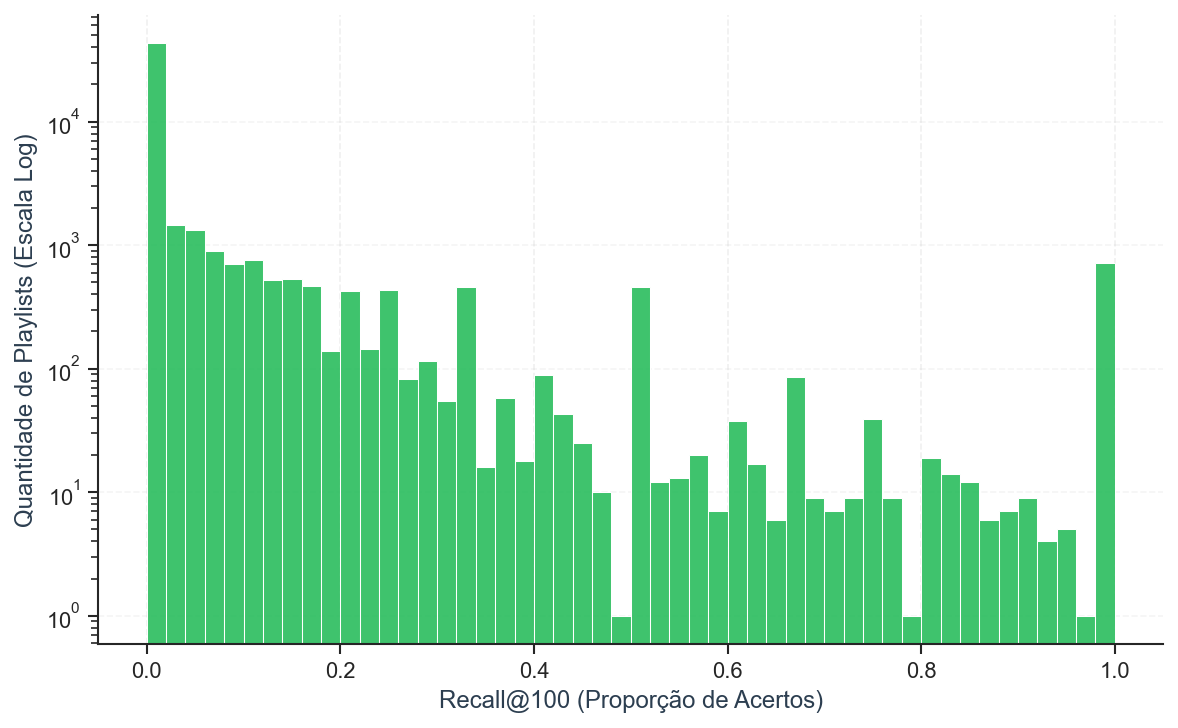

In [8]:
# ==============================================================================
# VISUALIZAÇÃO: Distribuição do Recall@100 por Playlist (Cold-Start)
# ==============================================================================

def plot_recall_histogram(save_name="recall_histogram.png"):
    """
    Mostra a variabilidade de desempenho do modelo em diferentes playlists.
    Carrega dados automaticamente de cold_start_metrics_per_playlist.parquet
    """
    print("Gerando Figura: Distribuição do Recall@100...")
    
    metrics_path = P['metrics'] / "cold_start_metrics_per_playlist.parquet"
    
    if not metrics_path.exists():
        print(f"   ⚠️ Arquivo não encontrado: {metrics_path}")
        return
    
    df = pd.read_parquet(metrics_path)
    
    if 'Recall@100' not in df.columns:
        print(f"   ⚠️ Coluna 'Recall@100' não encontrada")
        return
    
    n_playlists = len(df)
    mean_recall = df['Recall@100'].mean()
    median_recall = df['Recall@100'].median()
    
    print(f"   ✓ {n_playlists:,} playlists avaliadas")
    print(f"   ✓ Média: {mean_recall:.6f}, Mediana: {median_recall:.6f}")
    
    plt.figure(figsize=(8, 5))
    
    sns.histplot(
        df['Recall@100'],
        bins=50,
        kde=False,
        color=C_PRIMARY,
        edgecolor='white',
        linewidth=0.5,
        alpha=0.85
    )
    
    plt.yscale('log')
    plt.xlabel("Recall@100 (Proporção de Acertos)", color=C_NEUTRAL)
    plt.ylabel("Quantidade de Playlists (Escala Log)", color=C_NEUTRAL)
    
    sns.despine()
    plt.grid(True, which="major", axis="y", alpha=0.2, linestyle='--')
    plt.tight_layout()
    
    save_path = P['figures'] / save_name
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight', format='png')
    print(f"   ✓ Salvo em: {save_path}")
    plt.show()

plot_recall_histogram()